# Visualization of the CTLearn output
The output of CTLearn are stored in HDF5 format using pandas. 

### Import libraries
First, we need to import some libraries. 

In [1]:
# Data handling with numpy
import numpy as np
#np.set_printoptions(threshold=np.inf)

# Metric handling wit sklearn
from sklearn import metrics

# Reading the HDF5 file with pandas
import pandas as pd

# Plotting libraries
import ctaplot
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# (Default ctaplot) energy binning 
E_bin = np.logspace(np.log10(2.51e-02), 2, 19)
E = ctaplot.ana.logbin_mean(E_bin)

## Create the output file


In [2]:
files = {}
files['particle'] = {'Nocut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/particle/nocut.h5',
                     'Lowcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/particle/lowcut.h5',
                     'Midcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/particle/midcut.h5',
                     'Highcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/particle/highcut.h5'}
files['energy'] = {'Nocut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/energy/nocut.h5',
                   'Lowcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/energy/lowcut.h5',
                   'Midcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/energy/midcut.h5',
                   'Highcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/energy/highcut.h5',
                   'Nocut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/energy/nocut.h5',
                   'Lowcut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/energy/lowcut.h5',
                   'Midcut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/energy/midcut.h5',
                   'Highcut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/energy/highcut.h5'}
files['arrdir'] = {'Nocut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/arrdir/nocut.h5',
                   'Lowcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/arrdir/lowcut.h5',
                   'Midcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/arrdir/midcut.h5',
                   'Highcut_LegacyCNN': '/Users/tmiener/Desktop/updateconfig/lstmono_results/arrdir/highcut.h5',
                   'Nocut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/arrdir/nocut.h5',
                   'Lowcut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/arrdir/lowcut.h5',
                   'Midcut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/arrdir/midcut.h5',
                   'Highcut_ResNet50': '/Users/tmiener/Desktop/updateconfig/lstmono_results/resnet50/arrdir/highcut.h5'}

output_file_name = '/Users/tmiener/Desktop/updateconfig/lstmono_results/ctlearn_STLresults.h5'
output_file = pd.HDFStore(output_file_name)
# Particle classification
particle_metrics = {}
particle_key_label = 'LegacyCNN/Particle_classification'

for file in files['particle']:
    print(file)
    metric = []
    metric_keys = []
    data = pd.HDFStore(files['particle'][file], 'r')
    
    proton_prediction = data['proton']
    proton_mc_particle = np.array(proton_prediction['mc_particle']).astype(int)
    proton_reco_particle = np.array(proton_prediction['reco_particle']).astype(int)
    proton_reco_gammaness = np.array(proton_prediction['reco_gammaness']).astype(float)
        
    for gammatyp in ['diffuse', 'pointlike']: 
        if '/gamma_{}'.format(gammatyp) in data.keys():
            gamma_prediction = data['gamma_{}'.format(gammatyp)]
            gamma_mc_particle = np.array(gamma_prediction['mc_particle']).astype(int)
            gamma_reco_particle = np.array(gamma_prediction['reco_particle']).astype(int)
            gamma_reco_gammaness = np.array(gamma_prediction['reco_gammaness']).astype(float)
            
            # Concatenate the protons with the gammas (diffuse and pointlike)
            mc_particle = np.concatenate((proton_mc_particle, gamma_mc_particle))
            reco_particle = np.concatenate((proton_reco_particle, gamma_reco_particle))
            reco_gammaness = np.concatenate((proton_reco_gammaness, gamma_reco_gammaness))
            
            fpr, tpr, thresholds = metrics.roc_curve(mc_particle, reco_gammaness)
            
            '''
            # Save fpr, tpr and thresholds into the H5 file (increase file size from 90KB to 40MB)
            particle_roc = {}
            particle_roc_key_label = 'ROC_curve_{}_{}'.format(gammatyp, file)
            particle_roc['fpr'] = fpr
            particle_roc['tpr'] = tpr
            particle_roc['thresholds'] = thresholds
            if particle_roc_key_label in list(output_file.keys()):
                output_file.remove(particle_roc_key_label)
            pd.DataFrame(data=particle_roc).to_hdf(output_file_name, key=particle_roc_key_label, mode='a')
            '''
            
            # AUC
            metric.append(metrics.auc(fpr, tpr))
            metric_keys.append('AUC_{}'.format(gammatyp))
            # Acc score for the protons and gammas (diffuse and pointlike)
            metric.append(metrics.accuracy_score(mc_particle, reco_particle))
            metric_keys.append('Acc_{}'.format(gammatyp))
            # Acc score for the gammas (diffuse and pointlike) only
            metric.append(metrics.accuracy_score(gamma_mc_particle, gamma_reco_particle))
            metric_keys.append('Acc_gamma_{}'.format(gammatyp))


    # Acc score for the protons only
    metric.append(metrics.accuracy_score(proton_mc_particle, proton_reco_particle))
    metric_keys.append('Acc_proton')

    particle_metrics['{}'.format(file)] = metric

    for k, m in zip(metric_keys, metric):
        print("{} = {:0.3f}".format(k, m))
        
if particle_key_label in list(output_file.keys()):
    output_file.remove(particle_key_label)
pd.DataFrame(data=particle_metrics).to_hdf(output_file_name, key=particle_key_label, mode='a')

for cnn in ['LegacyCNN', 'ResNet50']:
    energy_datapoints = {}
    energy_key_label = '{}/Energy_regression'.format(cnn)

    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        data = pd.HDFStore(files['energy']['{}_{}'.format(cut, cnn)], 'r')
        for gammatyp in ['diffuse', 'pointlike']: 
            if '/gamma_{}'.format(gammatyp) in data.keys():
                prediction_data = data['gamma_{}'.format(gammatyp)]
                mc_energy = np.array(prediction_data['mc_energy'])
                reco_energy = np.array(prediction_data['reco_energy'])
            
                # Energy resolution
                ebin, eres = ctaplot.ana.energy_resolution_per_energy(mc_energy, reco_energy)
                energy_datapoints['Energy_resolution_{}_{}'.format(gammatyp, cut)] = eres[:,0]
                energy_datapoints['Energy_resolution_lower_{}_{}'.format(gammatyp, cut)] = eres[:,1]
                energy_datapoints['Energy_resolution_upper_{}_{}'.format(gammatyp, cut)] = eres[:,2]
                # Energy bias
                ebin, energy_datapoints['Energy_bias_{}_{}'.format(gammatyp, cut)] = ctaplot.ana.energy_bias(mc_energy, reco_energy)

    if energy_key_label in list(output_file.keys()):
        output_file.remove(energy_key_label)
    pd.DataFrame(data=energy_datapoints).to_hdf(output_file_name, key=energy_key_label, mode='a')

for cnn in ['LegacyCNN', 'ResNet50']:
    arrdir_datapoints = {}
    arrdir_key_label = '{}/ArrivalDirection_regression'.format(cnn)

    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        data = pd.HDFStore(files['arrdir']['{}_{}'.format(cut, cnn)], 'r')
        for gammatyp in ['diffuse', 'pointlike']: 
            if '/gamma_{}'.format(gammatyp) in data.keys():
                prediction_data = data['gamma_{}'.format(gammatyp)]
                mc_energy = np.array(prediction_data['mc_energy'])
                mc_alt = np.array(prediction_data['mc_altitude'])
                reco_alt = np.array(prediction_data['reco_altitude'])
                mc_az = np.array(prediction_data['mc_azimuth'])
                reco_az = np.array(prediction_data['reco_azimuth'])
            
                # Angular resolution
                ebin, angres = ctaplot.ana.angular_resolution_per_energy(reco_alt, reco_az, mc_alt, mc_az, mc_energy)
                angres = np.degrees(angres)
                arrdir_datapoints['Angular_resolution_{}_{}'.format(gammatyp, cut)] = angres[:,0]
                arrdir_datapoints['Angular_resolution_lower_{}_{}'.format(gammatyp, cut)] = angres[:,1]
                arrdir_datapoints['Angular_resolution_upper_{}_{}'.format(gammatyp, cut)] = angres[:,2]

    if arrdir_key_label in list(output_file.keys()):
        output_file.remove(arrdir_key_label)
    pd.DataFrame(data=arrdir_datapoints).to_hdf(output_file_name, key=arrdir_key_label, mode='a')

print("Results saved in '{}'".format(output_file_name))
output_file.close()

OSError: ``/Users/tmiener/Desktop/updateconfig/lstmono_results`` does not exist

### ROC curves

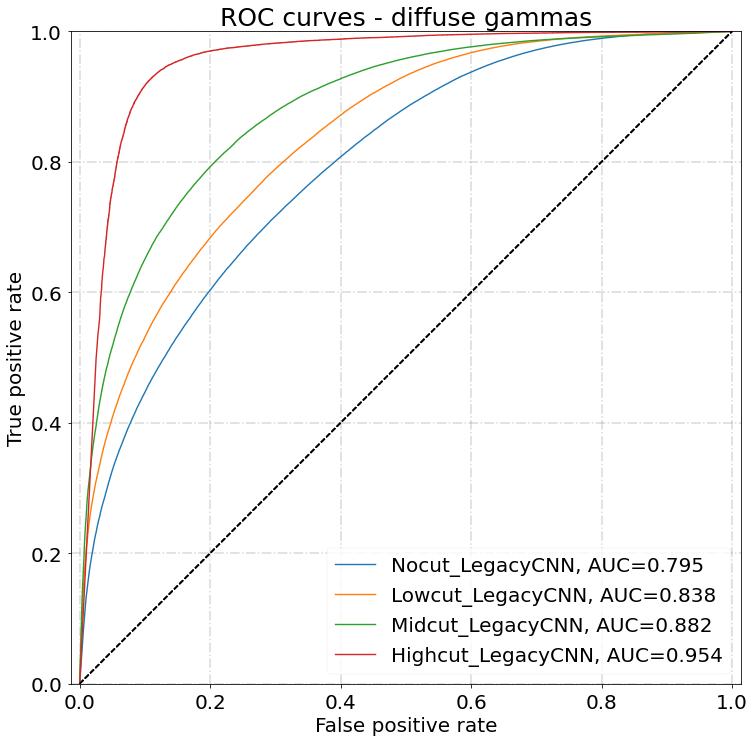

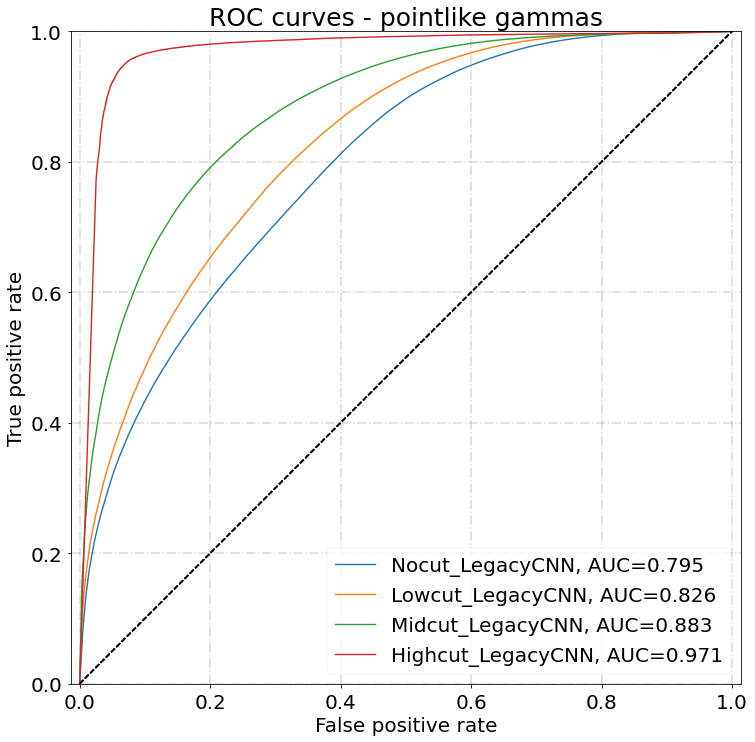

In [3]:
for gammatyp in ['diffuse', 'pointlike']:
    plt.figure(figsize=(12,12))
    ax = plt.axes()    
    
    for file in files['particle']:
        data = pd.HDFStore(files['particle'][file], 'r')
    
        if '/gamma_{}'.format(gammatyp) in data.keys():
            gamma_prediction = data['gamma_{}'.format(gammatyp)]
            gamma_mc_particle = np.array(gamma_prediction['mc_particle']).astype(int)
            gamma_reco_particle = np.array(gamma_prediction['reco_particle']).astype(int)
            gamma_reco_gammaness = np.array(gamma_prediction['reco_gammaness']).astype(float)
    
        proton_prediction = data['proton']
        proton_mc_particle = np.array(proton_prediction['mc_particle']).astype(int)
        proton_reco_particle = np.array(proton_prediction['reco_particle']).astype(int)
        proton_reco_gammaness = np.array(proton_prediction['reco_gammaness']).astype(float)

            
        # Concatenate the protons with the gammas (diffuse and pointlike)
        mc_particle = np.concatenate((proton_mc_particle, gamma_mc_particle))
        reco_particle = np.concatenate((proton_reco_particle, gamma_reco_particle))
        reco_gammaness = np.concatenate((proton_reco_gammaness, gamma_reco_gammaness))
        fpr, tpr, thresholds = metrics.roc_curve(mc_particle, reco_gammaness)
        ax = ctaplot.plot_roc_curve(mc_particle, reco_gammaness, label="{}, AUC={:0.3f}".format(file, metrics.auc(fpr, tpr)))
        
    ax.set_xlabel('False positive rate', fontsize=20)
    plt.xlim(0.0,1.0)
    ax.set_xticks([0.0,0.2,0.4,0.6,0.8,1.0])

    ax.set_ylabel('True positive rate', fontsize=20)
    plt.ylim(0.0,1.0)
    ax.set_yticks([0.0,0.2,0.4,0.6,0.8,1.0])

    ax.plot([0, 1], [0, 1], '--', color='black')
    #major grid lines
    ax.tick_params(labelsize=20)
    plt.grid(b=True, which='major', color='gray', alpha=0.3, linestyle='dashdot', lw=1.5)

    ax.legend(loc='lower right',fontsize=20)
    ax.set_title("ROC curves - {} gammas".format(gammatyp),fontsize=25)
    plt.savefig("/Users/tmiener/Desktop/updateconfig/lstmono_results/particle/roc_curves_{}.png".format(gammatyp))
    plt.show()

### Energy resolution 

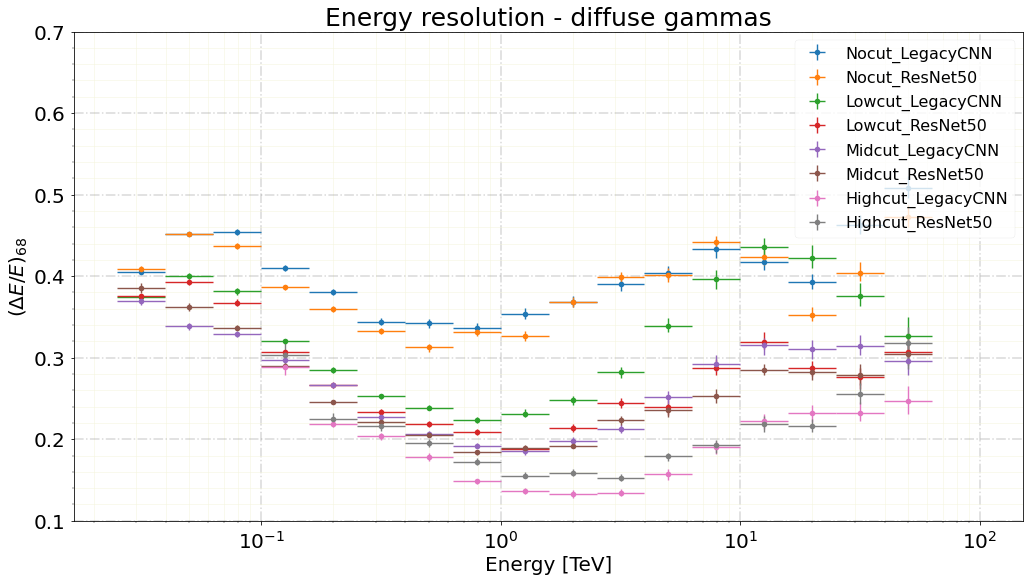

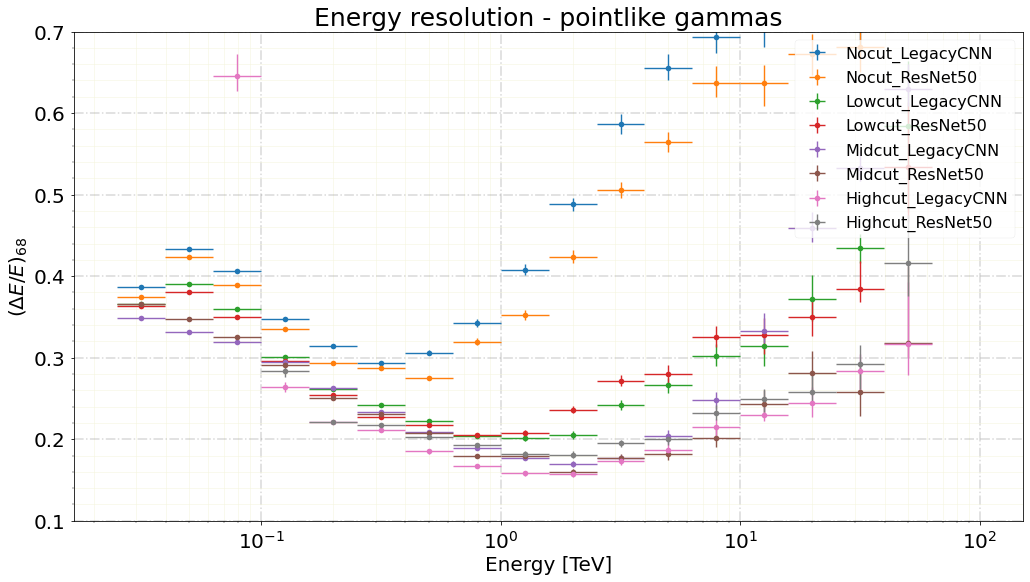

In [4]:
output_file_name = '/Users/tmiener/Desktop/updateconfig/lstmono_results/ctlearn_STLresults.h5'
data = pd.HDFStore(output_file_name, 'r')

for gammatyp in ['diffuse', 'pointlike']:
    fig, ax = plt.subplots(1,figsize=(17,9))
    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        
        for cnn in ['LegacyCNN', 'ResNet50']:
            energy_data = data['{}/Energy_regression'.format(cnn)]
            Eres = [energy_data['Energy_resolution_{}_{}'.format(gammatyp, cut)]]
            Eres.append(energy_data['Energy_resolution_lower_{}_{}'.format(gammatyp, cut)])
            Eres.append(energy_data['Energy_resolution_upper_{}_{}'.format(gammatyp, cut)])
            Eres = np.array(Eres).T
            
            ax.errorbar(E, Eres[:, 0], xerr=(E - E_bin[:-1], E_bin[1:] - E),
                        yerr=(Eres[:, 0] - Eres[:, 1], Eres[:, 2] - Eres[:, 0]),
                        label = '{}_{}'.format(cut, cnn), fmt = 'o')

    # Scale, labels and title
    ax.set_ylabel(r"$(\Delta E/E)_{68}$",fontsize=20)
    ax.set_ybound(0.1,0.7)
    ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
    ax.set_xlabel("Energy [TeV]",fontsize=20)
    ax.set_xscale('log')
    ax.set_title('Energy resolution - {} gammas'.format(gammatyp),fontsize=25)
    ax.tick_params(labelsize=20)

    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', alpha=0.3, linestyle='dashdot', lw=1.5)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)

    ax.legend(loc='upper right',fontsize=16)
    plt.savefig("/Users/tmiener/Desktop/updateconfig/lstmono_results/energy/energyresolution_{}gammas.png".format(gammatyp))
    plt.show()


### Energy bias

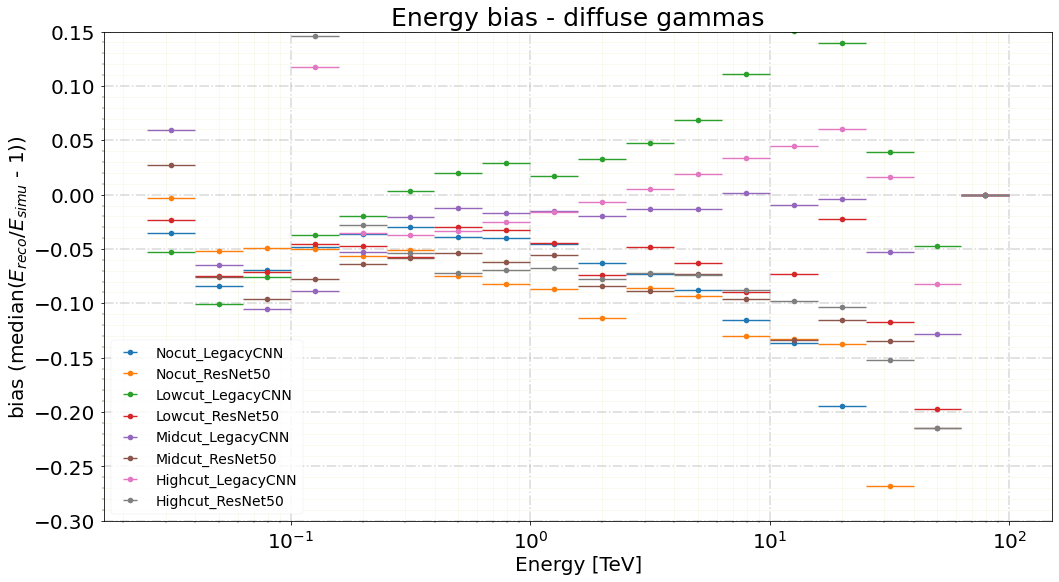

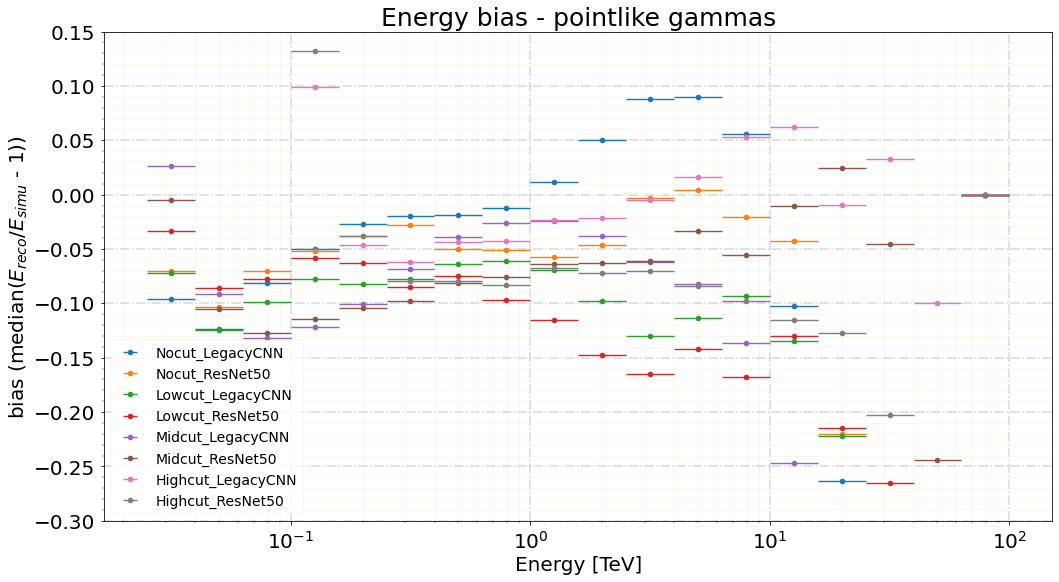

In [5]:
output_file_name = '/Users/tmiener/Desktop/updateconfig/lstmono_results/ctlearn_STLresults.h5'
data = pd.HDFStore(output_file_name, 'r')

for gammatyp in ['diffuse', 'pointlike']:
    fig, ax = plt.subplots(1,figsize=(17,9))
    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        
        for cnn in ['LegacyCNN', 'ResNet50']:
            energy_data = data['{}/Energy_regression'.format(cnn)]
            Ebias = energy_data['Energy_bias_{}_{}'.format(gammatyp, cut)]
            ax.errorbar(E, Ebias, xerr=(E - E_bin[:-1], E_bin[1:] - E), label = '{}_{}'.format(cut, cnn), fmt = 'o')
            
    # Scale, labels and title
    ax.set_ybound(-0.3,0.15)
    ax.set_yticks([-0.3,-0.25,-0.2,-0.15,-0.1,-0.05,0.0,0.05,0.1,0.15])
    ax.set_ylabel("bias (median($E_{reco}/E_{simu}$ - 1))",fontsize=20)
    ax.set_xlabel("Energy [TeV]",fontsize=20)
    ax.set_xscale('log')
    ax.set_title('Energy bias - {} gammas'.format(gammatyp), fontsize=25)
    ax.tick_params(labelsize=20)
    
    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', alpha=0.3, linestyle='dashdot', lw=1.5)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)

    ax.legend(loc='lower left',fontsize=14)
    plt.savefig("/Users/tmiener/Desktop/updateconfig/lstmono_results/energy/energybias_{}gammas.png".format(gammatyp))
    plt.show()


### Angular resolution

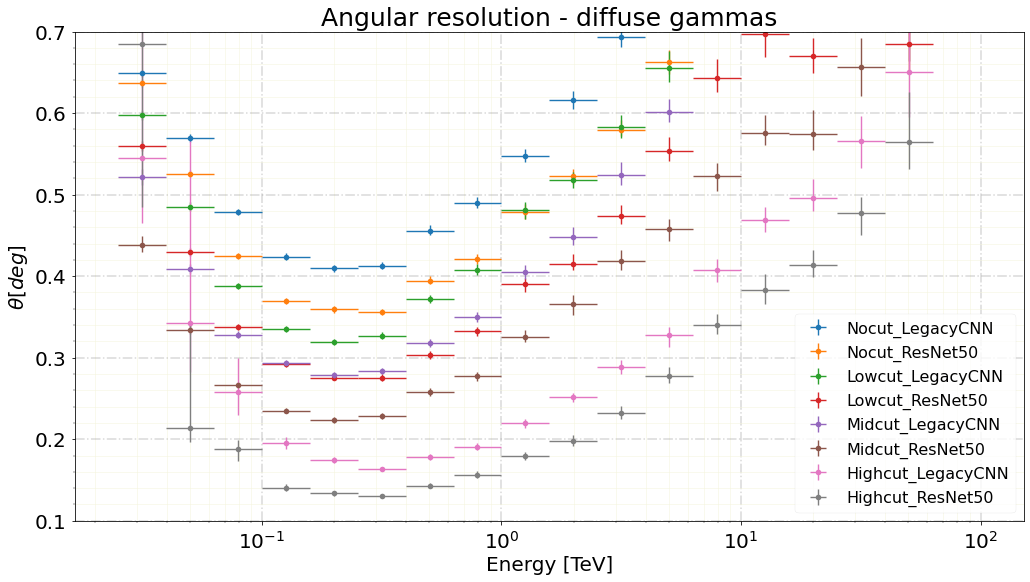

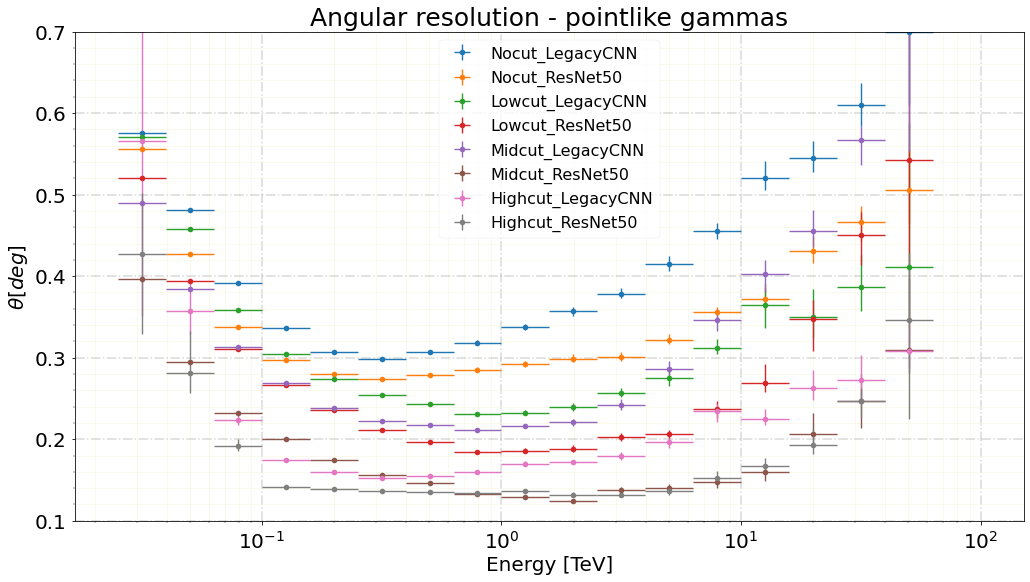

In [6]:
output_file_name = '/Users/tmiener/Desktop/updateconfig/lstmono_results/ctlearn_STLresults.h5'
data = pd.HDFStore(output_file_name, 'r')

for gammatyp in ['diffuse', 'pointlike']:
    fig, ax = plt.subplots(1,figsize=(17,9))
    for cut in ['Nocut', 'Lowcut', 'Midcut', 'Highcut']:
        
        for cnn in ['LegacyCNN', 'ResNet50']:
            angular_data = data['{}/ArrivalDirection_regression'.format(cnn)]
            Angres = [angular_data['Angular_resolution_{}_{}'.format(gammatyp, cut)]]
            Angres.append(angular_data['Angular_resolution_lower_{}_{}'.format(gammatyp, cut)])
            Angres.append(angular_data['Angular_resolution_upper_{}_{}'.format(gammatyp, cut)])
            Angres = np.array(Angres).T
            
            ax.errorbar(E, Angres[:, 0], xerr=(E - E_bin[:-1], E_bin[1:] - E),
                        yerr=(Angres[:, 0] - Angres[:, 1], Angres[:, 2] - Angres[:, 0]),
                        label = '{}_{}'.format(cut, cnn), fmt = 'o')

    # Scale, labels and title
    ax.set_ylabel(r'$\theta [deg]$',fontsize=20)
    ax.set_ybound(0.1,0.7)
    ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7])
    ax.set_xlabel("Energy [TeV]",fontsize=20)
    ax.set_xscale('log')
    ax.set_title('Angular resolution - {} gammas'.format(gammatyp),fontsize=25)

    ax.tick_params(labelsize=20)

    #major and minor grid lines
    plt.grid(b=True, which='major', color='gray', alpha=0.3, linestyle='dashdot', lw=1.5)
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='beige', alpha=0.5, ls='-', lw=1)
    
    if gammatyp == 'diffuse':
        ax.legend(loc='lower right',fontsize=16)
    elif gammatyp == 'pointlike':
        ax.legend(loc='upper center',fontsize=16)

    plt.savefig("/Users/tmiener/Desktop/updateconfig/lstmono_results/arrdir/arrdirresolution_{}gammas.png".format(gammatyp))
    plt.show()
